In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb

df = pd.read_csv('/content/Cleaned_data_to_run_ML.csv')

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create product-specific models
products = df['Product Name'].unique()
results = {}

for product in products:
    # Filter data for the current product
    product_df = df[df['Product Name'] == product].copy()
    product_df = product_df.sort_values('Date')

    # Feature engineering (in addition to existing features)
    product_df['year'] = product_df['Date'].dt.year
    product_df['quarter'] = product_df['Date'].dt.quarter

    # Create lag features (in addition to existing ones)
    for lag in [14, 30, 90]:
        product_df[f'lag_{lag}'] = product_df['Total Quantity'].shift(lag)

    # Create rolling features (in addition to existing ones)
    for window in [14, 30, 90]:
        product_df[f'rolling_mean_{window}'] = product_df['Total Quantity'].rolling(window=window).mean()
        product_df[f'rolling_std_{window}'] = product_df['Total Quantity'].rolling(window=window).std()
        product_df[f'rolling_min_{window}'] = product_df['Total Quantity'].rolling(window=window).min()
        product_df[f'rolling_max_{window}'] = product_df['Total Quantity'].rolling(window=window).max()

    # Drop rows with NaN values (from lag/rolling features)
    product_df = product_df.dropna()

    # Define features and target
    features = ['day_of_week', 'is_weekend', 'day_of_month', 'day_of_year',
                'month', 'week_of_year', 'lag_1', 'lag_7', 'rolling_mean_7',
                'year', 'quarter', 'lag_14', 'lag_30', 'lag_90',
                'rolling_mean_14', 'rolling_mean_30', 'rolling_mean_90',
                'rolling_std_14', 'rolling_std_30', 'rolling_std_90',
                'rolling_min_14', 'rolling_min_30', 'rolling_min_90',
                'rolling_max_14', 'rolling_max_30', 'rolling_max_90']

    X = product_df[features]
    y = product_df['Total Quantity']

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Train XGBoost model with time-series CV
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        xgb_scores.append(rmse)

    results[product] = {'XGBoost RMSE': np.mean(xgb_scores)}

    # Optional: Add LightGBM model here for comparison

# Print results
for product, metrics in results.items():
    print(f"Product: {product}")
    for model, rmse in metrics.items():
        print(f"  {model}: {rmse:.2f}")

<ipython-input-3-742387b30c2b>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Product: beef
  XGBoost RMSE: 12.85
Product: corn
  XGBoost RMSE: 12.74
Product: milk
  XGBoost RMSE: 16.27
Product: sugar
  XGBoost RMSE: 11.85
Product: wheat
  XGBoost RMSE: 25.75
Product: chocolate
  XGBoost RMSE: 13.13
Product: coffee
  XGBoost RMSE: 15.74
Product: soybeans
  XGBoost RMSE: 7.78


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

df = pd.read_csv('/content/Cleaned_data_to_run_ML.csv')

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create product-specific models
products = df['Product Name'].unique()
results = {}

for product in products:
    # Filter data for the current product
    product_df = df[df['Product Name'] == product].copy()
    product_df = product_df.sort_values('Date')

    # Feature engineering (in addition to existing features)
    product_df['year'] = product_df['Date'].dt.year
    product_df['quarter'] = product_df['Date'].dt.quarter

    # Create lag features (in addition to existing ones)
    for lag in [14, 30, 90]:
        product_df[f'lag_{lag}'] = product_df['Total Quantity'].shift(lag)

    # Create rolling features (in addition to existing ones)
    for window in [14, 30, 90]:
        product_df[f'rolling_mean_{window}'] = product_df['Total Quantity'].rolling(window=window).mean()
        product_df[f'rolling_std_{window}'] = product_df['Total Quantity'].rolling(window=window).std()
        product_df[f'rolling_min_{window}'] = product_df['Total Quantity'].rolling(window=window).min()
        product_df[f'rolling_max_{window}'] = product_df['Total Quantity'].rolling(window=window).max()

    # Drop rows with NaN values (from lag/rolling features)
    product_df = product_df.dropna()

    # Define features and target
    features = ['day_of_week', 'is_weekend', 'day_of_month', 'day_of_year',
                'month', 'week_of_year', 'lag_1', 'lag_7', 'rolling_mean_7',
                'year', 'quarter', 'lag_14', 'lag_30', 'lag_90',
                'rolling_mean_14', 'rolling_mean_30', 'rolling_mean_90',
                'rolling_std_14', 'rolling_std_30', 'rolling_std_90',
                'rolling_min_14', 'rolling_min_30', 'rolling_min_90',
                'rolling_max_14', 'rolling_max_30', 'rolling_max_90']

    X = product_df[features]
    y = product_df['Total Quantity']

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Train XGBoost model with time-series CV
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    xgb_rmse_scores = []
    xgb_mae_scores = []
    xgb_r2_scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        xgb_rmse_scores.append(rmse)
        xgb_mae_scores.append(mae)
        xgb_r2_scores.append(r2)

    results[product] = {
        'XGBoost RMSE': np.mean(xgb_rmse_scores),
        'XGBoost MAE': np.mean(xgb_mae_scores),
        'XGBoost R²': np.mean(xgb_r2_scores)
    }

# Print results
for product, metrics in results.items():
    print(f"Product: {product}")
    for model, score in metrics.items():
        print(f"  {model}: {score:.2f}")


<ipython-input-4-fd1d2176f12a>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Product: beef
  XGBoost RMSE: 12.85
  XGBoost MAE: 10.24
  XGBoost R²: 0.11
Product: corn
  XGBoost RMSE: 12.74
  XGBoost MAE: 10.16
  XGBoost R²: 0.19
Product: milk
  XGBoost RMSE: 16.27
  XGBoost MAE: 12.74
  XGBoost R²: 0.47
Product: sugar
  XGBoost RMSE: 11.85
  XGBoost MAE: 9.42
  XGBoost R²: 0.09
Product: wheat
  XGBoost RMSE: 25.75
  XGBoost MAE: 20.36
  XGBoost R²: 0.37
Product: chocolate
  XGBoost RMSE: 13.13
  XGBoost MAE: 10.41
  XGBoost R²: 0.22
Product: coffee
  XGBoost RMSE: 15.74
  XGBoost MAE: 12.50
  XGBoost R²: 0.29
Product: soybeans
  XGBoost RMSE: 7.78
  XGBoost MAE: 6.06
  XGBoost R²: 0.04


Adding more lag features and checking fr seasonality

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import holidays

df = pd.read_csv('/content/Cleaned_data_to_run_ML.csv')

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define holidays (example: US holidays, modify as needed)
us_holidays = holidays.US()

# Create product-specific models
products = df['Product Name'].unique()
results = {}

for product in products:
    # Filter data for the current product
    product_df = df[df['Product Name'] == product].copy()
    product_df = product_df.sort_values('Date')

    # Feature Engineering
    product_df['year'] = product_df['Date'].dt.year
    product_df['quarter'] = product_df['Date'].dt.quarter
    product_df['month'] = product_df['Date'].dt.month
    product_df['week_of_year'] = product_df['Date'].dt.isocalendar().week
    product_df['day_of_week'] = product_df['Date'].dt.dayofweek
    product_df['is_weekend'] = (product_df['day_of_week'] >= 5).astype(int)
    product_df['is_holiday'] = product_df['Date'].apply(lambda x: 1 if x in us_holidays else 0)

    # Placeholder for external data (e.g., promotions, weather effects)
    product_df['promo_event'] = np.random.randint(0, 2, product_df.shape[0])  # Fake promo event feature
    product_df['weather_impact'] = np.random.uniform(0, 1, product_df.shape[0])  # Fake weather effect

    # Create lag features
    for lag in [7, 14, 21, 30, 60, 90]:
        product_df[f'lag_{lag}'] = product_df['Total Quantity'].shift(lag)

    # Create rolling features
    for window in [7, 14, 21, 30, 60, 90]:
        product_df[f'rolling_mean_{window}'] = product_df['Total Quantity'].rolling(window=window).mean()
        product_df[f'rolling_std_{window}'] = product_df['Total Quantity'].rolling(window=window).std()
        product_df[f'rolling_min_{window}'] = product_df['Total Quantity'].rolling(window=window).min()
        product_df[f'rolling_max_{window}'] = product_df['Total Quantity'].rolling(window=window).max()

    # Drop rows with NaN values (from lag/rolling features)
    product_df = product_df.dropna()

    # Define features and target
    features = ['year', 'quarter', 'month', 'week_of_year', 'day_of_week', 'is_weekend',
                'is_holiday', 'promo_event', 'weather_impact',
                'lag_7', 'lag_14', 'lag_21', 'lag_30', 'lag_60', 'lag_90',
                'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_21', 'rolling_mean_30', 'rolling_mean_60', 'rolling_mean_90',
                'rolling_std_7', 'rolling_std_14', 'rolling_std_21', 'rolling_std_30', 'rolling_std_60', 'rolling_std_90',
                'rolling_min_7', 'rolling_min_14', 'rolling_min_21', 'rolling_min_30', 'rolling_min_60', 'rolling_min_90',
                'rolling_max_7', 'rolling_max_14', 'rolling_max_21', 'rolling_max_30', 'rolling_max_60', 'rolling_max_90']

    X = product_df[features]
    y = product_df['Total Quantity']

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Hyperparameter Grid for Tuning XGBoost
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0]
    }

    xgb_model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search.fit(X, y)

    best_xgb_model = grid_search.best_estimator_

    # Evaluate Model with Cross-validation
    xgb_rmse_scores = []
    xgb_mae_scores = []
    xgb_r2_scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_xgb_model.fit(X_train, y_train)
        y_pred = best_xgb_model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        xgb_rmse_scores.append(rmse)
        xgb_mae_scores.append(mae)
        xgb_r2_scores.append(r2)

    results[product] = {
        'XGBoost RMSE': np.mean(xgb_rmse_scores),
        'XGBoost MAE': np.mean(xgb_mae_scores),
        'XGBoost R²': np.mean(xgb_r2_scores),
        'Best Parameters': grid_search.best_params_
    }

# Print results
for product, metrics in results.items():
    print(f"\nProduct: {product}")
    for metric, value in metrics.items():
        if metric == "Best Parameters":
            print(f"  {metric}: {value}")
        else:
            print(f"  {metric}: {value:.2f}")


<ipython-input-5-469f4966b474>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])



Product: beef
  XGBoost RMSE: 12.67
  XGBoost MAE: 10.16
  XGBoost R²: 0.14
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

Product: corn
  XGBoost RMSE: 12.21
  XGBoost MAE: 9.78
  XGBoost R²: 0.25
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

Product: milk
  XGBoost RMSE: 16.39
  XGBoost MAE: 12.84
  XGBoost R²: 0.46
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}

Product: sugar
  XGBoost RMSE: 11.42
  XGBoost MAE: 9.11
  XGBoost R²: 0.16
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Product: wheat
  XGBoost RMSE: 24.55
  XGBoost MAE: 19.42
  XGBoost R²: 0.43
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Product: chocolate
  XGBoost RMSE: 12.93
  XGBoost MAE: 10.26
  XGBoost R²: 0.24
  Best Parameters: {'learning_rate': 0.05, '

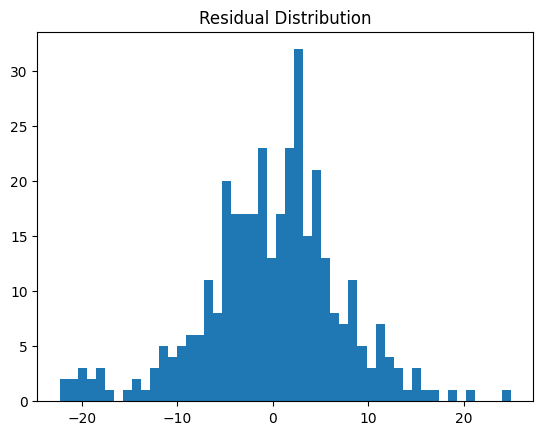

In [6]:
import matplotlib.pyplot as plt
plt.hist(y_test - y_pred, bins=50)
plt.title("Residual Distribution")
plt.show()


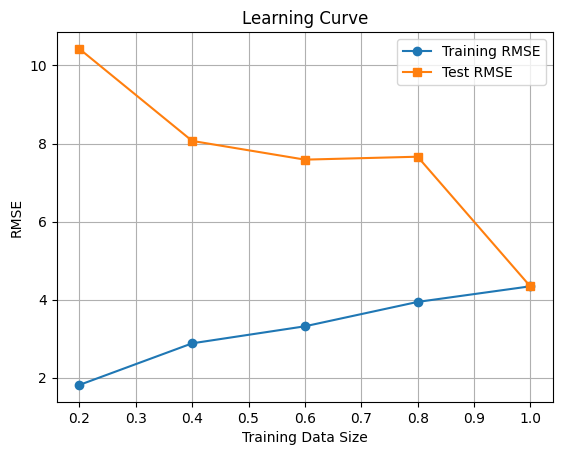

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
train_scores = []
test_scores = []

for size in train_sizes:
    subset_size = int(len(X) * size)
    X_train_sub, y_train_sub = X.iloc[:subset_size], y.iloc[:subset_size]
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
    model.fit(X_train_sub, y_train_sub)

    train_pred = model.predict(X_train_sub)
    test_pred = model.predict(X_test)

    # Fix: Manually compute RMSE without `squared` argument
    train_scores.append(np.sqrt(mean_squared_error(y_train_sub, train_pred)))
    test_scores.append(np.sqrt(mean_squared_error(y_test, test_pred)))

plt.plot(train_sizes, train_scores, label="Training RMSE", marker='o')
plt.plot(train_sizes, test_scores, label="Test RMSE", marker='s')
plt.xlabel("Training Data Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


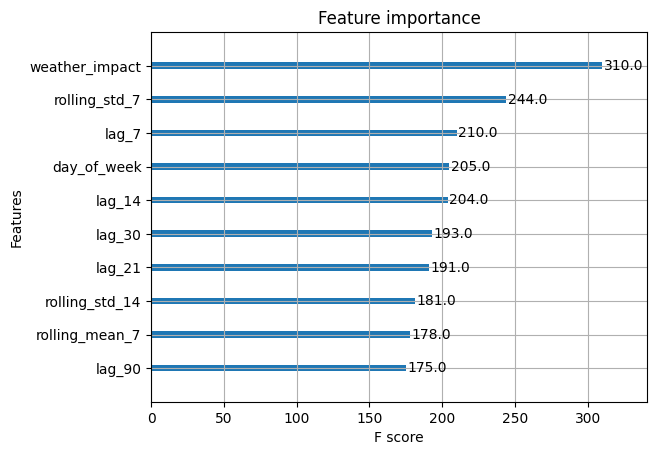

In [8]:
xgb_model.fit(X, y)
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()


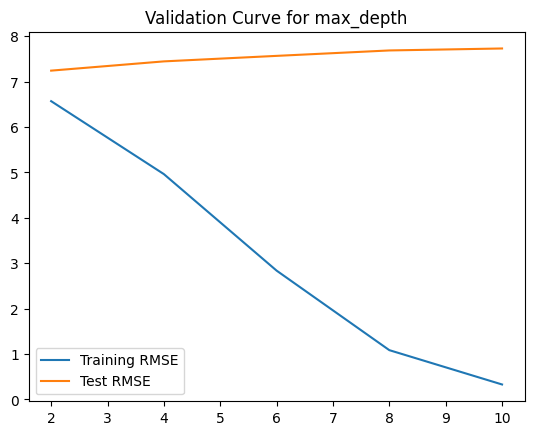

In [9]:
from sklearn.model_selection import validation_curve

param_range = [2, 4, 6, 8, 10]
train_scores, test_scores = validation_curve(
    xgb.XGBRegressor(n_estimators=200, learning_rate=0.05),
    X, y, param_name="max_depth", param_range=param_range, cv=5, scoring="neg_root_mean_squared_error")

plt.plot(param_range, -train_scores.mean(axis=1), label="Training RMSE")
plt.plot(param_range, -test_scores.mean(axis=1), label="Test RMSE")
plt.legend()
plt.title("Validation Curve for max_depth")
plt.show()
